# ShopCo
## Predicting Fraud with Imbalanced Data

In [1]:
import os 
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import CVScores
from yellowbrick.features import PCADecomposition
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.features import ParallelCoordinates
from yellowbrick.classifier import ClassificationReport 
from yellowbrick.model_selection import ValidationCurve 
from yellowbrick.model_selection import FeatureImportances

from sklearn.metrics import f1_score
from sklearn.externals import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split as tts

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# About the data

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
# Load the data into a Pandas dataframe
# get a sample count 
fraud_data = pd.read_csv("data/"+"creditcard.csv")
print(
    "There are {} instances contained in the dataset.".format(
        len(fraud_data)
    )
)
fraud_data.head()

There are 284807 instances contained in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fraud_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Assume the store is online and thus technically always open
first_purchase = datetime.datetime(2013, 9, 1, 0, 0, 0, 0)
print(first_purchase)

2013-09-01 00:00:00


In [5]:
# Create a timestamp column using the Time (in seconds)
# from the initial purchase
fraud_data["timestamp"] = fraud_data.apply(
    lambda row: datetime.timedelta(seconds=row.Time) + first_purchase, 
    axis=1
)

In [6]:
# Create a day column using the timestamp
fraud_data["day"] = fraud_data["timestamp"].dt.to_period('D')

In [7]:
talk_colors=[
    "#41294a", "#d23733", "#e6403b", "#fef2e2",
    "#fde5c5", "#f7b100", "#f39904"
]
talk_palette = sns.color_palette(talk_colors)

In [8]:
# Create an hour column using the timestamp
fraud_data["hour"] = fraud_data["timestamp"].dt.to_period('H')

In [9]:
# ax = sns.countplot(
#     x="hour", 
#     data=fraud_data,
#     palette=talk_palette
# )
# ax.set_title("Purchases by hour")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)

# plt.show()

In [10]:
# # Is fraud more common at certain times of day? 
# ax = sns.countplot(
#     x="hour",
#     data=fraud_data[fraud_data["Class"] == 1],
#     palette=talk_palette
# )
# ax.set_title("Fraudulent activities by hour")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)
# plt.show()

# Target analysis

In [11]:
# Reduce feature space to metrics only for preliminary model 
features = [
    "V1", "V2", "V3", "V4", "V5", "V6", 
    "V7", "V8", "V9", "V10", "Amount"
]
classes = ["Non-Fraud", "Fraud"]

# Separate the features from the target values
X = fraud_data[features].values
y = fraud_data["Class"].values

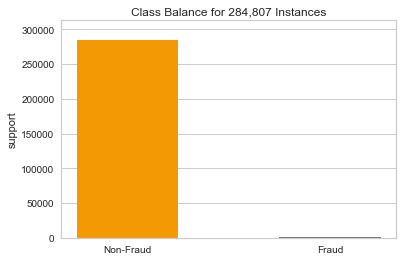

In [12]:
# Let's check to see how balanced our classes our,
# which may help us to anticipate any modeling challenges 
# we might experience downstream in our workflow.
class_balance = ClassBalance(
    labels=classes, 
    colors=["#f39904", "#e6403b"]
)
class_balance.fit(y)
class_balance.show()

In [13]:
# The data are very imbalanced!
fraud_cases = fraud_data[fraud_data["Class"] == 1]
print(
    "Thankfully, fraud only occurred in {} percent of cases.".format(
        len(fraud_cases)/len(fraud_data) * 100
    )
)

Thankfully, fraud only occurred in 0.1727485630620034 percent of cases.


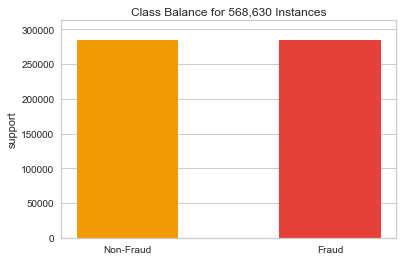

In [14]:
# Oversample the minority class 
smote = SMOTE(random_state=42)
X_up, y_up = smote.fit_resample(X, y)
class_balance = ClassBalance(
    labels=classes, 
    colors=["#f39904", "#e6403b"]
)
class_balance.fit(y_up)
class_balance.show()

# Feature Analysis and Wrangling

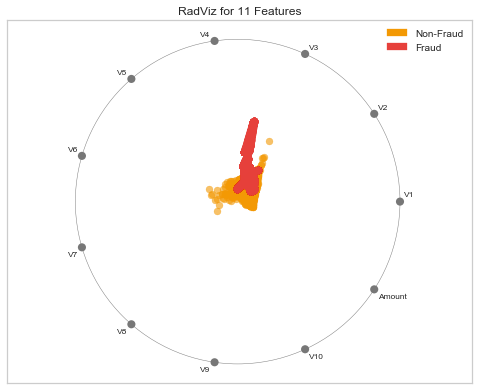

In [15]:
radviz = RadViz(
     classes=classes, features=features, alpha=0.6,
     colors=["#f39904", "#e6403b"], size=(600, 480)
 )
radviz.fit(X_up, y_up)
radviz.transform(X_up)
radviz.show()

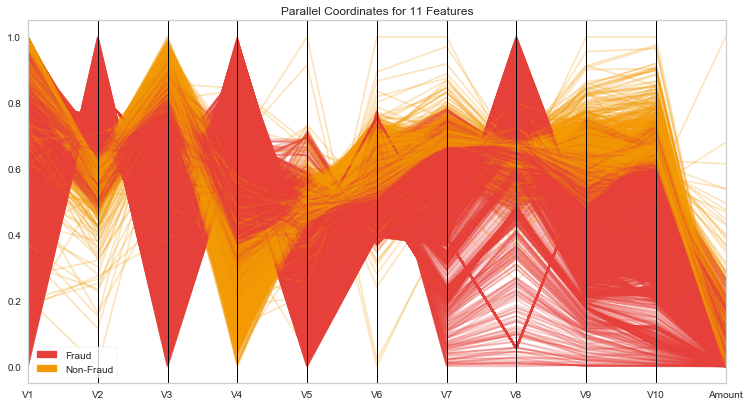

In [16]:
pcoords = ParallelCoordinates(
    classes=classes, features=features, sample=0.05,
    shuffle=True, normalize="minmax", size=(900, 480),
    colors=["#f39904", "#e6403b"]
)
pcoords.fit_transform(X_up, y_up)
pcoords.show()

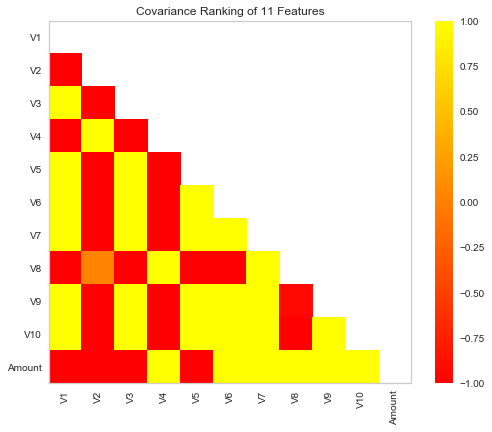

In [17]:
rank2d = Rank2D(
    algorithm="covariance", features=features,
    size=(600, 480), colormap="autumn"
)
rank2d.fit(X_up, y_up)
rank2d.transform(X_up)
rank2d.show()

# Feature Elimination

In [18]:
rfe = RFE(
    RandomForestClassifier(n_estimators=10), 
    n_features_to_select=5, 
    step=1
)
rfe.fit(X_up, y_up)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [19]:
rfe.support_

array([False,  True,  True,  True, False, False,  True, False, False,
        True, False])

In [20]:
new_features = [
    feature for feature, val in zip(features,rfe.support_)
    if val   
]

In [21]:
new_features

['V2', 'V3', 'V4', 'V7', 'V10']

In [22]:
new_X = fraud_data[new_features].values
smote = SMOTE(random_state=42)
X_up, y_up = smote.fit_resample(new_X, y)

# Modeling

In [23]:
models = [
    ExtraTreesClassifier(n_estimators=10),
    RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=10)
] 

In [24]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        "{}:{}".format(
            model.__class__.__name__, 
            f1_score(y_test, y_pred)
        )
    )

ExtraTreesClassifier:0.9989403564449225
RandomForestClassifier:0.9983336793743578
GradientBoostingClassifier:0.9341301563041194


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


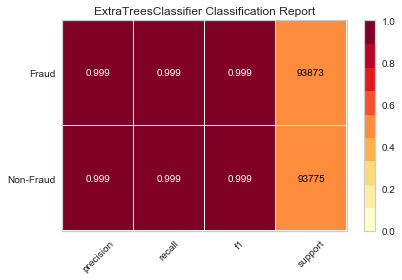

In [25]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

clf_report = ClassificationReport(
    ExtraTreesClassifier(n_estimators=10),
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show()  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


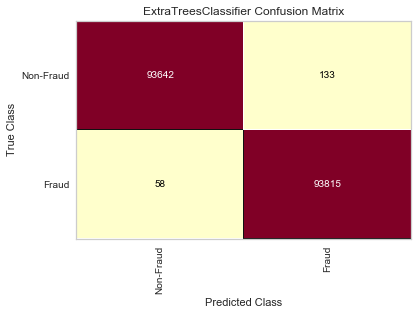

In [26]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

clf_report = ConfusionMatrix(
    ExtraTreesClassifier(n_estimators=10),
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show() 